Importing libraries

In [1]:
# importing the required libraries
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# checking pytorch version
print(torch.__version__)

2.2.0


In [3]:
import torchvision
# checking if cuda is available
torch.cuda.is_available()

True

In [4]:
# setting the device to cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Dataset download and setup

In [5]:
# File handling
current_path = os.getcwd()
new_path = os.path.join(current_path, 'Cropped_final\Cropped_final')
os.chdir(new_path)
for i in os.listdir():
    print(i)

amur_leopard
amur_tiger
birds
black_bear
brown_bear
dog
people
roe_deer
sika_deer
wild_boar


Dataset Class

In [6]:
class RussianWildLifeDataset(Dataset):
  def __init__(self, root_dir, transform):
    self.transform = transform
    self.root_dir = root_dir
    self.classes = os.listdir(self.root_dir)
    self.classes.sort()
    self.class_index_mapping = dict(zip(range(len(self.classes)), self.classes))
    self.__load_data__()

  def __load_data__(self):
    self.images_filenames = []
    self.labels = []
    for i in range(len(self.class_index_mapping)):
      # go to the class directory
      os.chdir(new_path)
      class_path = os.path.join(self.root_dir, self.class_index_mapping[i])
      for image in os.listdir(class_path):
        self.images_filenames.append(os.path.join(class_path, image))
        self.labels.append(i)

  def get_class_name(self, label):
    return self.class_index_mapping[label]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = im.open(self.images_filenames[idx])
    label = self.labels[idx]
    if (self.transform):
      image = self.transform(image)
    label_value = label
    sample = {'image': image, 'label': label, 'label_value': label_value}
    return sample

Transformations

In [7]:
composed_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Dataset and DataLoaders

In [9]:
dataset = RussianWildLifeDataset(new_path, composed_transform)
all_labels = [sample['label_value'] for sample in dataset]
train_data, testing_data, train_labels, testing_labels = train_test_split(dataset, all_labels, train_size=0.7, stratify=all_labels, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(testing_data, testing_labels, train_size=0.33, stratify=testing_labels, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [10]:
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

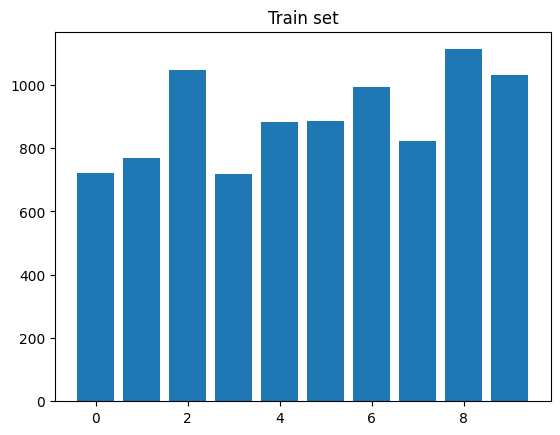

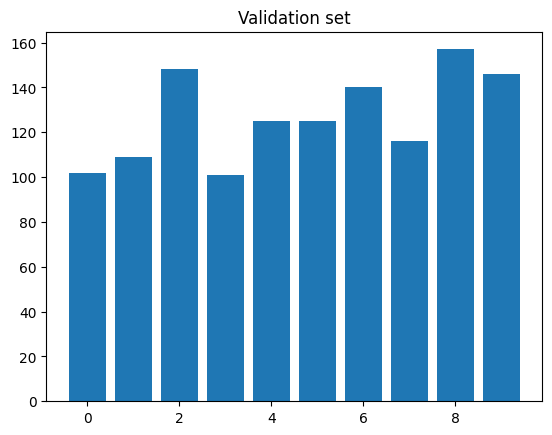

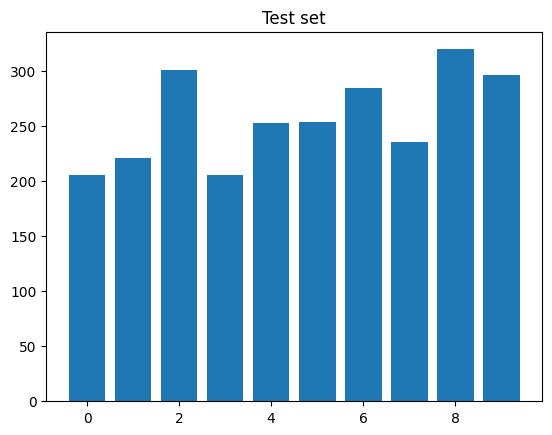

In [11]:
def plot_distribution(data, title):
  labels = [sample['label_value'] for sample in data]
  unique, counts = np.unique(labels, return_counts=True)
  plt.bar(unique, counts)
  plt.title(title)
  plt.show()

plot_distribution(train_data, 'Train set')
plot_distribution(val_data, 'Validation set')
plot_distribution(test_data, 'Test set')

In [12]:
print(os.getcwd())
os.chdir("..")
os.chdir("..")
print(os.getcwd())

c:\Users\prakh\OneDrive\Documents\GitHub\CV_Assignments\A1\Cropped_final\Cropped_final
c:\Users\prakh\OneDrive\Documents\GitHub\CV_Assignments\A1


WandB Setup


In [13]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prakhar432. Use `wandb login --relogin` to force relogin


True

In [14]:
model_config = dict(
    epochs=10,
    classes=10,
    kernels=[3, 3, 3],
    features=[32, 64, 128],
    batch_size=16,
    optimizer="Adam",
    learning_rate=0.001,
    dataset="Russian WildLife Dataset",
    architecture="ResNet18", 
    type="Fine-Tuning", 
    learning="full",
    weights="IMAGENET1K",
    weight_initialisation="Default")

In [15]:
run_num = 2
wandb.init(
    project = "Computer_Vision_A1",
    name = f"Q2_B_Experiment_{run_num}",
    config = model_config,
)

Visualizing Training Data

In [29]:
# reversing the normalization to get back the original image
def tensor_to_image(tensor): # Used from the link below*
    # Reversing the normalization
    for t, m, s in zip(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    # Converting tensor to PIL image
    image = transforms.ToPILImage()(tensor)
    return image

# Citation: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/15

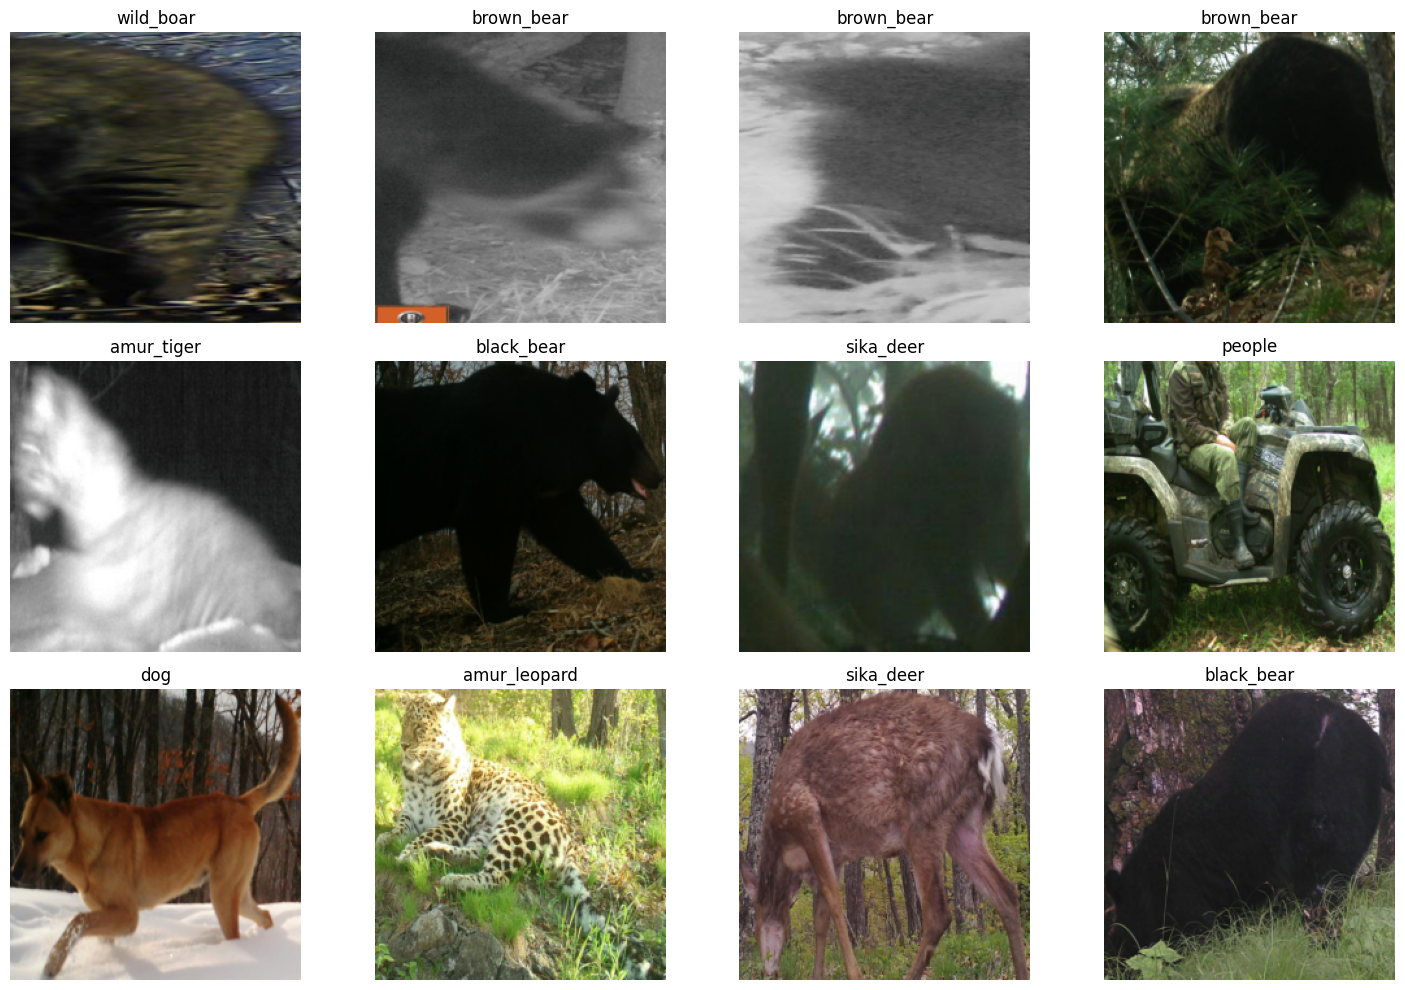

In [30]:
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= train_size:
            break
        sample = train_data[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label_value'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        # image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        image = tensor_to_image(sample['image'])
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

Visualizing Validation Data


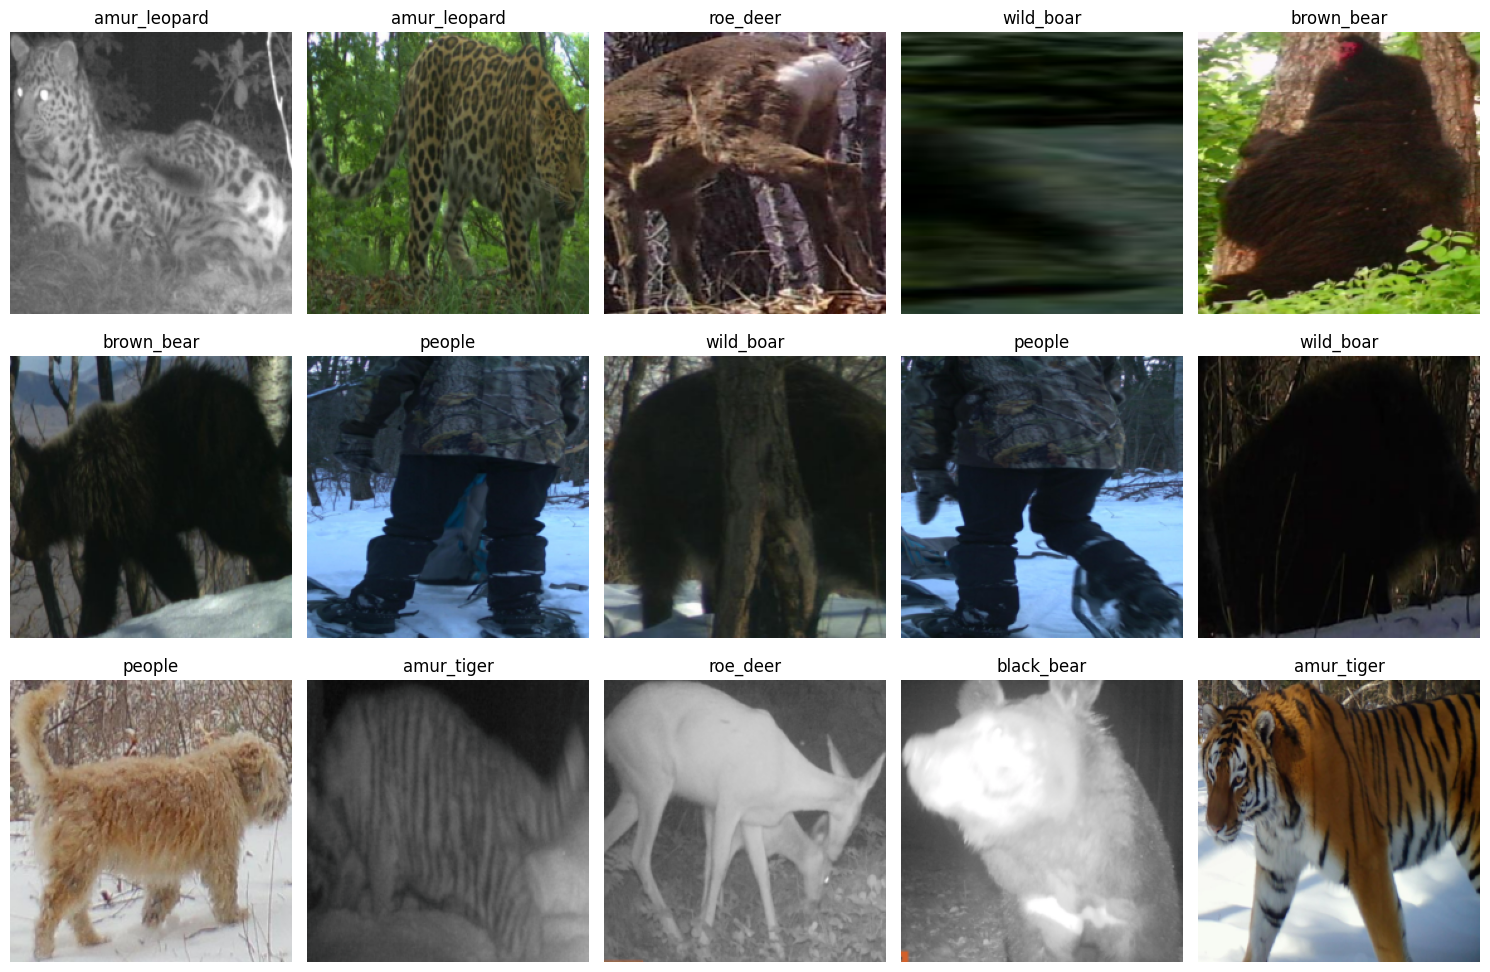

In [31]:
num_rows = 3
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(val_data):
            break
        sample = val_data[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label_value'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = tensor_to_image(sample['image'])
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

In [18]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1, progress=True)
# freezing the model parameters
for param in model.parameters():
    param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, 10)
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# move the model to the gpu
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
def loss_acc_calc(dataloader):
  with torch.no_grad():
    correct, total, loss = 0, 0, 0.0
    for i, sample in enumerate(dataloader, 0):
      images = sample['image']
      labels = sample['label']
      images = images.to(device)
      labels = torch.tensor(labels).to(device)
      forwards = model.forward(images)
      logits = F.softmax(forwards, dim=1)
      preds = torch.argmax(logits, dim=1)
      correct += torch.eq(preds, labels).sum().item()
      total += labels.size(0)
      loss_val = loss_fn(forwards, labels)
      loss += loss_val.item()
  return correct, total, loss

In [20]:
wandb.watch(model)

[]

In [21]:
def train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader):
    running_loss = 0.0
    for epoch in range(model_config['epochs']):
        for i, sample in enumerate(train_dataloader, 0):
            inputs = sample['image']
            labels = sample['label']
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)
            # zero the gradients before backprop
            optimizer.zero_grad()
            # forward pass
            logits = model.forward(inputs)
            loss = loss_fn(logits, labels)
            # backward pass
            loss.backward()
            optimizer.step()
            minibatch_loss = loss.item()
            running_loss += minibatch_loss
            # logging the minibatch after every batch, and running loss after every 100 minibatches
            wandb.log({'minibatch_loss': minibatch_loss})
            if (i%100==0):
                wandb.log({'running_loss': running_loss / 100})
                running_loss = 0.0
        # log the training accuracy and loss
        correct, total, loss = loss_acc_calc(train_dataloader)
        wandb.log({'train_loss': loss / len(train_dataloader), 'train_accuracy': (correct / total) * 100.0})
        # log the validation accuracy and loss
        correct, total, loss = loss_acc_calc(val_dataloader)
        wandb.log({'val_loss': loss / len(val_dataloader), 'val_accuracy': (correct / total) * 100.0})
    # save the model after training
    torch.save(model.state_dict(), f"A1_Q2_ResNet_Experiment_{run_num}.pth")
    return model

In [22]:
# training the model 
model = train_model(model, model_config, loss_fn, optimizer, train_dataloader, val_dataloader)

In [23]:
def evaluation_metris_calc(dataloader):
    y_true = []
    y_pred = []
    for i, sample in enumerate(dataloader, 0):
        images = sample['image']
        labels = sample['label']
        images = images.to(device)
        labels = torch.tensor(labels).to(device)
        forwards = model.forward(images)
        logits = F.softmax(forwards, dim=1)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

In [24]:
# testing the model 
correct, total, loss = loss_acc_calc(test_dataloader)
print(f"Test Accuracy: {(correct / total) * 100.0}%")
wandb.log({'test_accuracy': (correct / total) * 100.0})
# calculate the metrics
y_true, y_pred = evaluation_metris_calc(test_dataloader)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
# logging the metrics onto wandb
confusion_matrix = wandb.plot.confusion_matrix(y_true=y_true, preds=y_pred, class_names=dataset.classes)
wandb.run.summary["test_accuracy"] = (correct / total) * 100.0
wandb.run.summary["f1_score"] = f1
wandb.run.summary["precision"] = precision
wandb.run.summary["recall"] = recall

Test Accuracy: 12.40791004265219%
F1 Score: 0.027420795674369478
Precision: 0.015413552848015143
Recall: 0.12407910042652191


In [25]:
wandb.finish()

In [33]:
# finding 3 misclassifications for each class and display them 
misclassifications = {}
for i in range(len(dataset.classes)):
    misclassifications[i] = []
for i, sample in enumerate(dataset, 0):
    image = sample['image']
    label = sample['label']
    if (len(misclassifications[label]) == 3):
        continue
    image = image.to(device)
    label = torch.tensor(label).to(device)
    forwards = model.forward(image.unsqueeze(0))
    logits = F.softmax(forwards, dim=1)
    pred = torch.argmax(logits, dim=1)
    if pred != label:
        # convert label to cpu numpy
        label = int(label.cpu().numpy())
        if len(misclassifications[label]) < 3:
            misclassifications[label].append([image.cpu(), pred])
    # if all classes have 3 misclassifications, break the loop
    if all(len(v) == 3 for v in misclassifications.values()):
        break

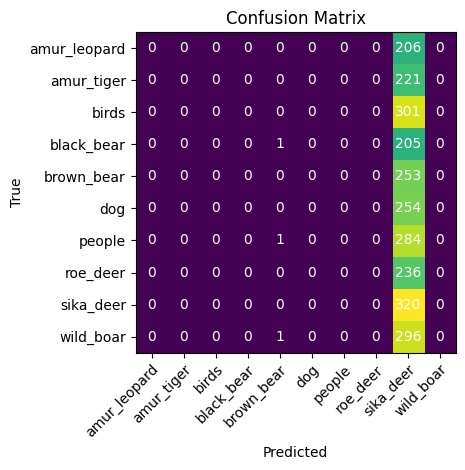

In [41]:
# plot confusion matrix for the test set
confusion_matrix = torch.zeros(len(dataset.classes), len(dataset.classes))
for i, sample in enumerate(test_data, 0):
    image = sample['image']
    label = sample['label']
    image = image.to(device)
    label = torch.tensor(label).to(device)
    forwards = model.forward(image.unsqueeze(0))
    logits = F.softmax(forwards, dim=1)
    pred = torch.argmax(logits, dim=1)
    label = int(label.cpu().numpy())
    pred = int(pred.cpu().numpy())
    confusion_matrix[label, pred] += 1
confusion_matrix = confusion_matrix.numpy()
# plot the confusion matrix along with class names and values
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='viridis')
ax.set_xticks(np.arange(len(dataset.classes)))
ax.set_yticks(np.arange(len(dataset.classes)))
ax.set_xticklabels(dataset.classes)
ax.set_yticklabels(dataset.classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(dataset.classes)):
    for j in range(len(dataset.classes)):
        text = ax.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="w")
ax.set_title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
fig.tight_layout()
plt.show()

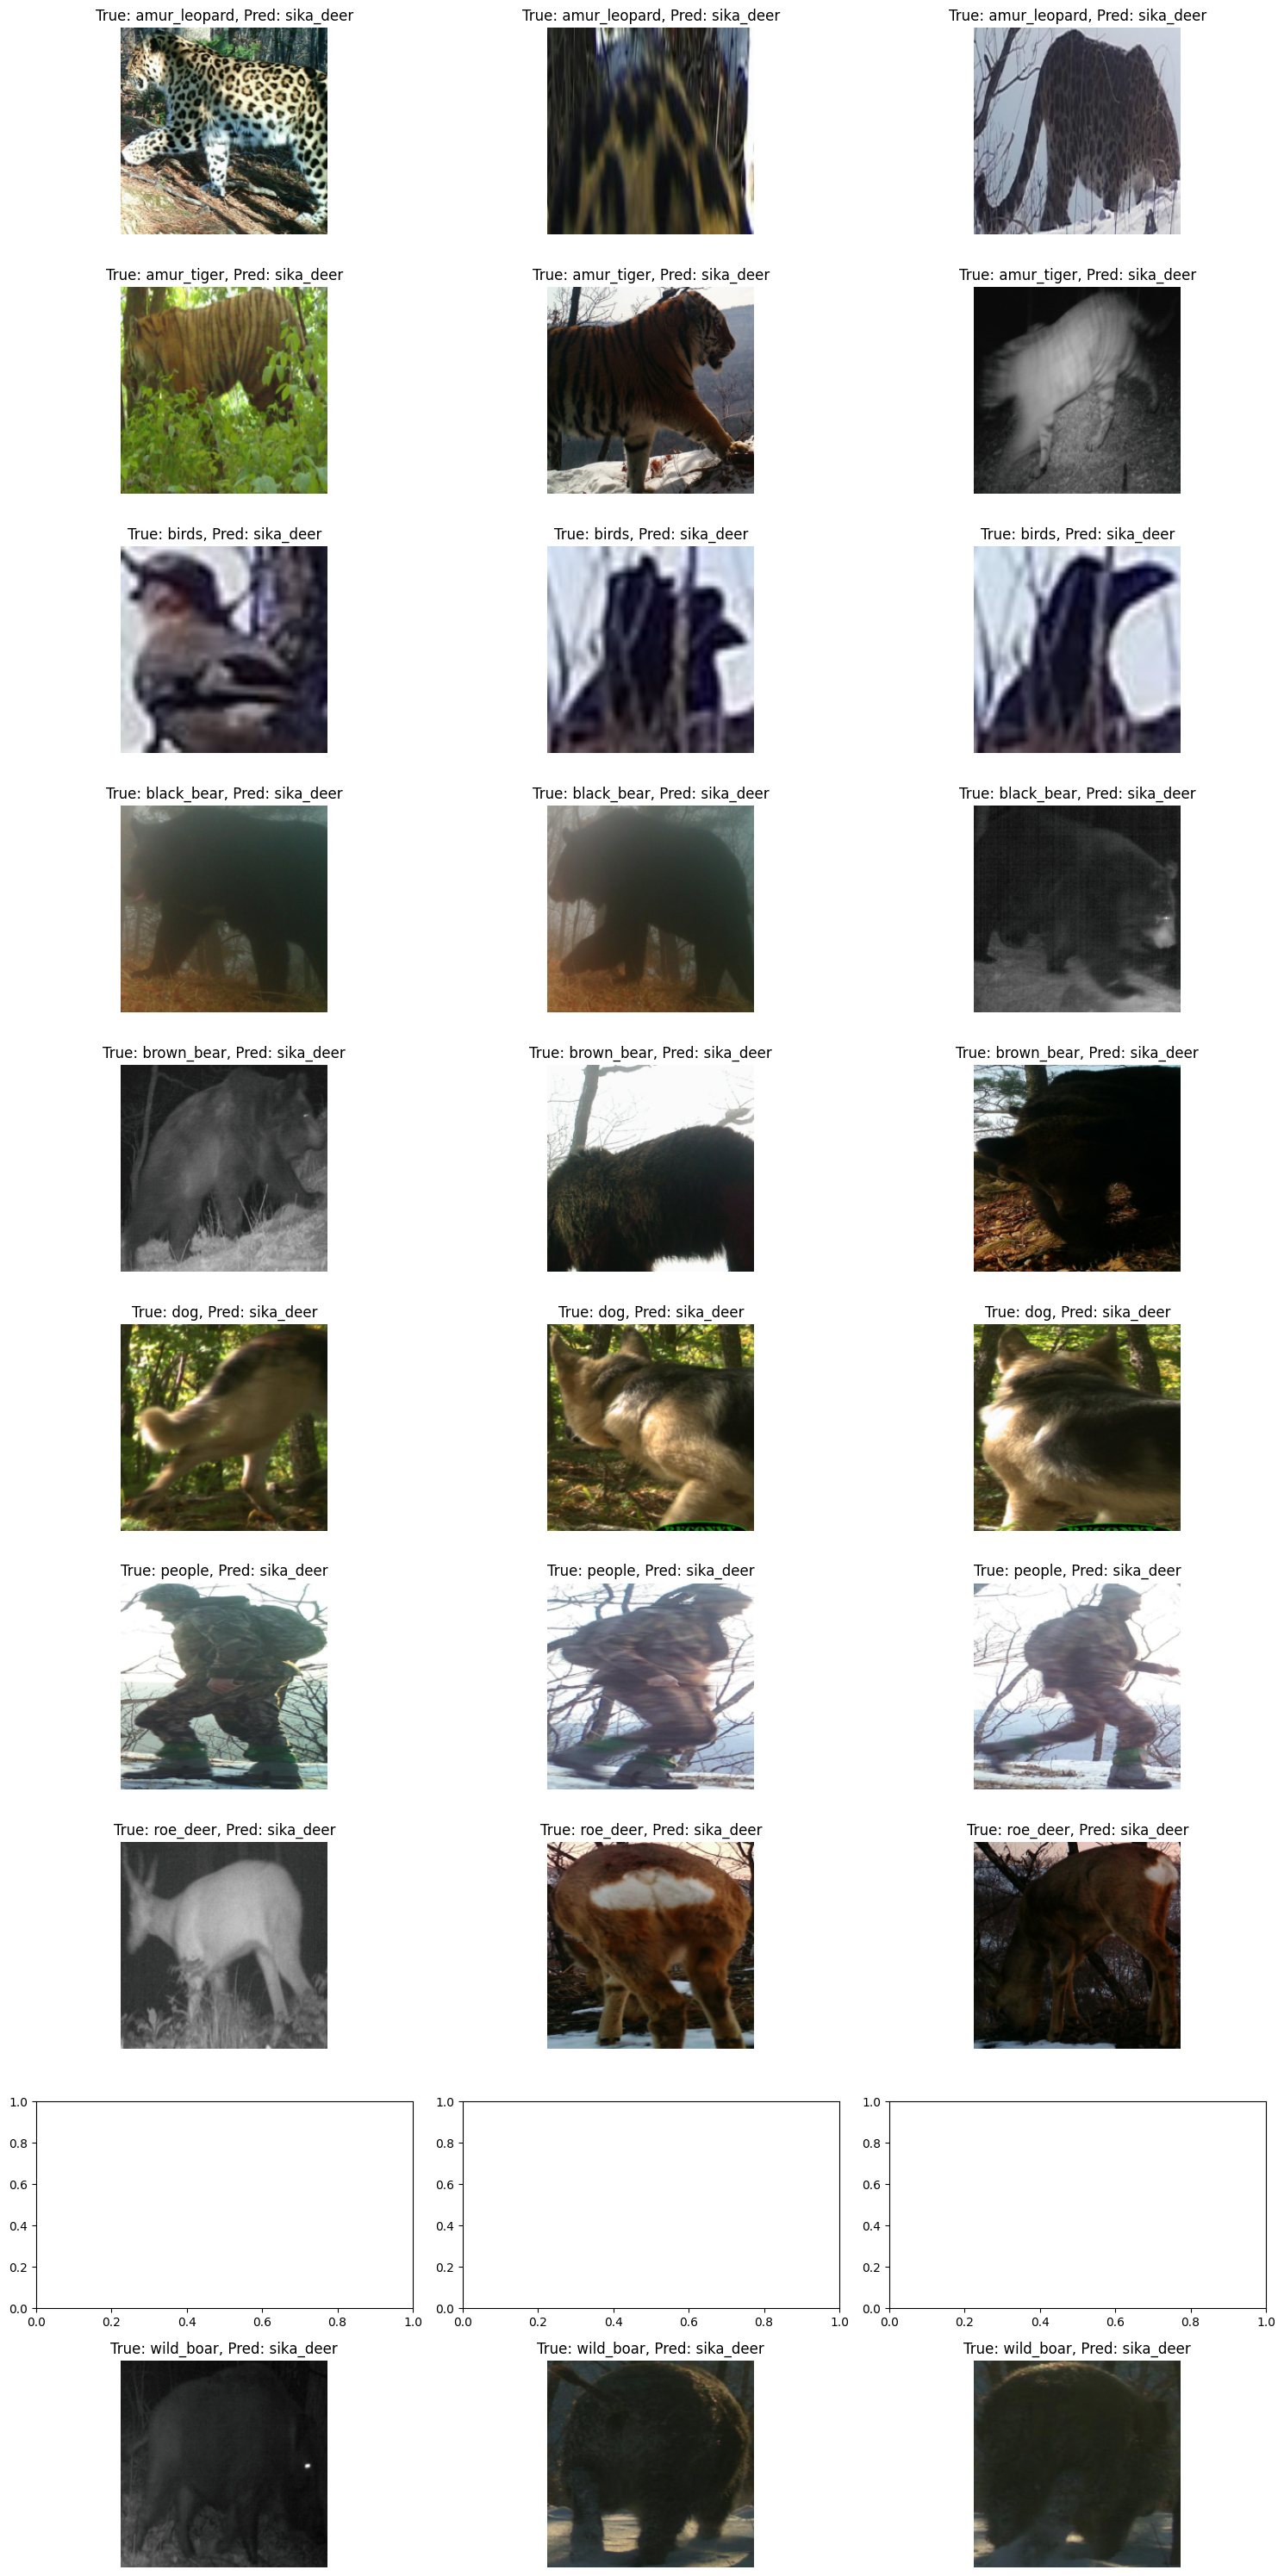

In [34]:
# display the misclassifications
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 30))
for i in range(10):
    for j in range(len(misclassifications[i])):
        label = i
        image, pred = misclassifications[label][j]
        pred_class = dataset.get_class_name(int(pred.cpu().numpy()))
        # actual_class = dataset.get_class_name(int(label.cpu().numpy()))
        axs[i, j].set_title(f"True: {dataset.get_class_name(label)}, Pred: {pred_class}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = tensor_to_image(image)
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()